In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
import re

from sklearn.neighbors import NearestNeighbors
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR


df_train = pd.read_csv('autos.csv')
df_train.head()

,index,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,...,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,...,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,...,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,...,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,...,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,...,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


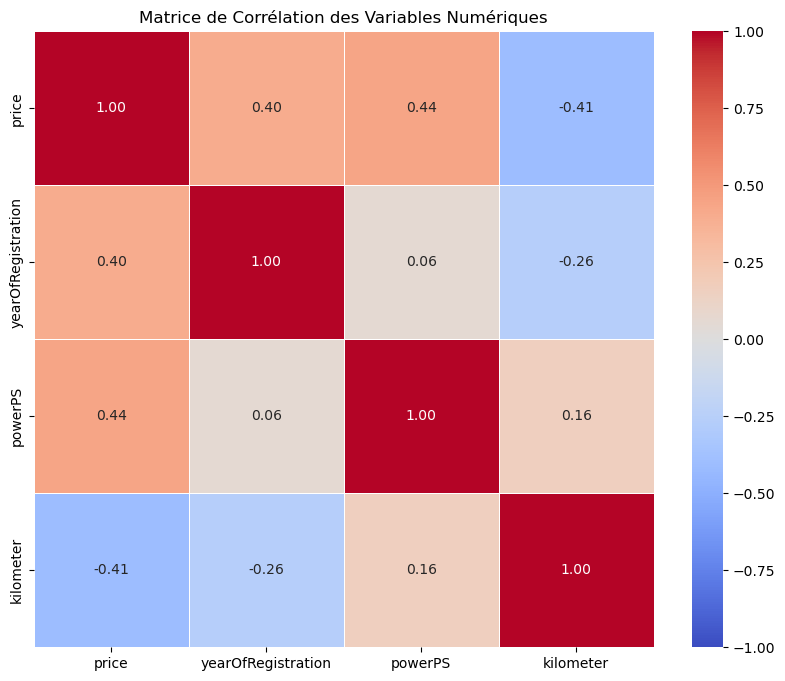

In [25]:


# 2. Sélection des variables numériques
# On inclut souvent le mois, mais il est rarement corrélé. On se concentre sur l'essentiel.
numeric_cols = ['price', 'yearOfRegistration', 'powerPS', 'kilometer']
corr_matrix = df_train[numeric_cols].corr()

# 3. Tracé de la Matrice de Corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matrice de Corrélation des Variables Numériques')
plt.show()

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Chargement et Nettoyage (Cohérence)
df1 = pd.read_csv('autos.csv', encoding='latin-1')
df1 = df1.drop_duplicates()
# Filtrage
df_clean = df1[(df1['price'] >= 500) & (df1['price'] <= 50000)].copy()
df_clean = df_clean[(df_clean['yearOfRegistration'] >= 1950) & (df_clean['yearOfRegistration'] <= 2017)]
df_clean = df_clean[(df_clean['powerPS'] >= 10) & (df_clean['powerPS'] <= 600)]

# Conversion de dateCreated en datetime
df_clean['dateCreated'] = pd.to_datetime(df_clean['dateCreated'])

# Style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# --- 1. Violin Plot (Alternative aux Boxplots) ---
# Permet de voir la densité de la distribution (forme) en plus des quartiles
plt.figure()
sns.violinplot(x='vehicleType', y='price', data=df_clean, palette='muted', inner="quartile")
plt.title('Distribution de densité des Prix par Type de Véhicule (Violin Plot)')
plt.xticks(rotation=45)
plt.xlabel('Type de Véhicule')
plt.ylabel('Prix (€)')
plt.tight_layout()
plt.savefig('violin_price_vehicle.png')
plt.close()

# --- 2. Hexbin Plot (Alternative aux Scatter plots pour grands datasets) ---
# Gère le "surchartage" (overplotting) en comptant les points dans des hexagones
plt.figure()
# On utilise matplotlib directement pour hexbin
plt.hexbin(df_clean['powerPS'], df_clean['price'], gridsize=30, cmap='Blues', bins='log')
plt.colorbar(label='Nombre de véhicules (log)')
plt.title('Relation Puissance vs Prix (Hexbin Plot)')
plt.xlabel('Puissance (PS)')
plt.ylabel('Prix (€)')
plt.tight_layout()
plt.savefig('hexbin_power_price.png')
plt.close()

# --- 3. Stacked Bar Chart (Relation entre deux catégorielles) ---
# Composition du carburant pour chaque type de véhicule
ct = pd.crosstab(df_clean['vehicleType'], df_clean['fuelType'], normalize='index')
ct.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6))
plt.title('Répartition des Carburants par Type de Véhicule')
plt.xlabel('Type de Véhicule')
plt.ylabel('Proportion')
plt.legend(title='Carburant', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('stacked_fuel_vehicle.png')
plt.close()

# --- 4. Time Series (Séries Temporelles) ---
# Volume d'annonces créées par jour
ads_per_day = df_clean.groupby(df_clean['dateCreated'].dt.date).size()
plt.figure(figsize=(14, 6))
ads_per_day.plot(kind='line', color='darkcyan', linewidth=1.5)
plt.title('Évolution du nombre d\'annonces créées par jour')
plt.xlabel('Date')
plt.ylabel('Nombre d\'annonces')
plt.tight_layout()
plt.savefig('timeseries_ads.png')
plt.close()

print("Nouvelles visualisations générées : violin_price_vehicle.png, hexbin_power_price.png, stacked_fuel_vehicle.png, timeseries_ads.png")

C:\Users\hugod\AppData\Local\Temp\ipykernel_82716\4050512250.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='vehicleType', y='price', data=df_clean, palette='muted', inner="quartile")


Nouvelles visualisations générées : violin_price_vehicle.png, hexbin_power_price.png, stacked_fuel_vehicle.png, timeseries_ads.png


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   index                371528 non-null  int64 
 1   dateCrawled          371528 non-null  object
 2   name                 371528 non-null  object
 3   seller               371528 non-null  object
 4   offerType            371528 non-null  object
 5   price                371528 non-null  int64 
 6   abtest               371528 non-null  object
 7   vehicleType          333659 non-null  object
 8   yearOfRegistration   371528 non-null  int64 
 9   gearbox              351319 non-null  object
 10  powerPS              371528 non-null  int64 
 11  model                351044 non-null  object
 12  kilometer            371528 non-null  int64 
 13  monthOfRegistration  371528 non-null  int64 
 14  fuelType             338142 non-null  object
 15  brand                371528 non-nu

# **<font color='red'>Deuxième partie : Prédiction</font>**



## **<font color='blue'>Prétraitement de nos données</font>**

### Traitement des valeurs manquantes :

Voici le nombre de valeurs manquantes par colonne, et le pourcentage associé :

In [4]:
Valeurs_manquantes = df_train.isnull().sum().to_frame('Valeurs_manquantes')
total_rows = df_train.shape[0]

Valeurs_manquantes[' Pourcentage de valeurs manquantes'] = ((Valeurs_manquantes['Valeurs_manquantes'] / total_rows) * 100).round(2) .astype(str) + ' %'
print(Valeurs_manquantes)

a = df_train.isnull().any(axis=1).sum()

print("\nLe nombre de lignes avec au minimum une valeur manquante dans une colonne est donc :", a, "soit environ ", ((a/df_train.shape[0])*100).round(2), " %")

                     Valeurs_manquantes  Pourcentage de valeurs manquantes
index                                 0                              0.0 %
dateCrawled                           0                              0.0 %
name                                  0                              0.0 %
seller                                0                              0.0 %
offerType                             0                              0.0 %
price                                 0                              0.0 %
abtest                                0                              0.0 %
vehicleType                       37869                            10.19 %
yearOfRegistration                    0                              0.0 %
gearbox                           20209                             5.44 %
powerPS                               0                              0.0 %
model                             20484                             5.51 %
kilometer                

Notre première idée était de supprimer toutes les lignes du dataset contenant au minimum une valeur manquante. Néanmoins, nous avons réaliser qu'il y a pas loin de 50% de valeurs manquantes donc cette solution n'est plus envisageable car cela fausserait toalement nos prédictions si uniquement la moitié du dataset est traitée. Nous allons donc analyser et traiter les colonnes au cas par cas :

In [ ]:
def traitement(df):
    """
    Nettoyage du dataset automobile :
    - suppression des colonnes inutiles (postalCode conservé)
    - imputation des valeurs manquantes
    """

 
    cols_to_drop = [
        'index',
        'name',
        'dateCrawled',
        'dateCreated',
        'lastSeen',
        'seller',
        'offerType',
        'nrOfPictures'
    ]

    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

    # ---------------------------
    # 2) Imputation par mode pour les catégorielles
    # ---------------------------
    mode_cols = ['vehicleType', 'gearbox', 'model', 'fuelType']

    for col in mode_cols:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mode()[0])

    # ---------------------------
    # 3) Cas spécial : notRepairedDamage
    # ---------------------------
    if 'notRepairedDamage' in df.columns:
        df['notRepairedDamage'] = df['notRepairedDamage'].fillna('unknown')

    return df

df_train = traitement(df_train)

In [6]:
Valeurs_manquantes = df_train.isnull().sum().to_frame('Valeurs_manquantes')

total_rows = df_train.shape[0]

Valeurs_manquantes[' Pourcentage de valeurs manquantes'] = ((Valeurs_manquantes['Valeurs_manquantes'] / total_rows) * 100).round(2) .astype(str) + ' %'
print(Valeurs_manquantes)

                     Valeurs_manquantes  Pourcentage de valeurs manquantes
price                                 0                              0.0 %
abtest                                0                              0.0 %
vehicleType                           0                              0.0 %
yearOfRegistration                    0                              0.0 %
gearbox                               0                              0.0 %
powerPS                               0                              0.0 %
model                                 0                              0.0 %
kilometer                             0                              0.0 %
monthOfRegistration                   0                              0.0 %
fuelType                              0                              0.0 %
brand                                 0                              0.0 %
notRepairedDamage                     0                              0.0 %
postalCode               

In [7]:
duplicates = df_train[df_train.duplicated()]
print(duplicates)

        price   abtest vehicleType  yearOfRegistration    gearbox  powerPS  \
3964     2999     test   limousine                2002    manuell      101   
4094      500  control  kleinwagen                1999    manuell       55   
4332    18750  control   limousine                2014    manuell      150   
5058     5500  control   limousine                2000    manuell      170   
7314     1699     test      cabrio                1996  automatik      101   
...       ...      ...         ...                 ...        ...      ...   
371437   2200     test       coupe                2002    manuell      147   
371455   8940  control   limousine                2009    manuell       80   
371463    600     test  kleinwagen                1999    manuell       54   
371493   3299     test   limousine                2005  automatik        0   
371513   4400  control   limousine                2008    manuell      105   

            model  kilometer  monthOfRegistration fuelType     

In [8]:
signature_cols = [
    'brand',
    'model',
    'yearOfRegistration',
    'monthOfRegistration',
    'gearbox',
    'fuelType',
    'powerPS',
    'kilometer'
]

In [9]:
def doublon(df, strict=False):
    """
    Gère les doublons dans le dataset automobile.

    strict = True  -> supprime uniquement les doublons parfaitement identiques
    strict = False -> supprime aussi les doublons quasi identiques basés sur une signature véhicule
    """

    # 1) Doublons stricts
    nb_avant = df.shape[0]
    df = df.drop_duplicates(keep='first')
    nb_apres_strict = df.shape[0]

    print(f"Doublons stricts supprimés : {nb_avant - nb_apres_strict}")

    # 2) Doublons avancés (signature véhicule)
    if not strict:
        signature_cols = [
            'brand',
            'model',
            'yearOfRegistration',
            'monthOfRegistration',
            'gearbox',
            'fuelType',
            'powerPS',
            'kilometer'
        ]

        # Création de la signature
        df['signature'] = df[signature_cols].astype(str).agg('_'.join, axis=1)

        nb_avant_signature = df.shape[0]
        
        # Suppression des doublons basés sur la signature
        df = df.drop_duplicates(subset='signature', keep='first')
        nb_apres_signature = df.shape[0]

        print(f"Doublons avancés (signature véhicule) supprimés : {nb_avant_signature - nb_apres_signature}")

        # Suppression de la colonne signature
        df = df.drop(columns=['signature'])

    print(f"Nombre final de lignes : {df.shape[0]}")

    return df

df_train = doublon(df_train)

Doublons stricts supprimés : 14658
Doublons avancés (signature véhicule) supprimés : 137971
Nombre final de lignes : 218899


C:\Users\hugod\AppData\Local\Temp\ipykernel_82716\4035947574.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signature'] = df[signature_cols].astype(str).agg('_'.join, axis=1)


In [10]:
def outlier(df):
    """
    Supprime les valeurs aberrantes du dataset automobile
    via règles métier + méthode statistique IQR.
    """

    df_clean = df.copy()

    # ---------------------------
    # 1) Outliers PRICE
    # ---------------------------
    # Filtrage métier
    df_clean = df_clean[(df_clean['price'] >= 500) & (df_clean['price'] <= 150000)]

    # IQR
    Q1 = df_clean['price'].quantile(0.25)
    Q3 = df_clean['price'].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df_clean = df_clean[(df_clean['price'] >= lower) & (df_clean['price'] <= upper)]

    # ---------------------------
    # 2) Outliers powerPS
    # ---------------------------
    # Filtrage métier
    df_clean = df_clean[(df_clean['powerPS'] >= 40) & (df_clean['powerPS'] <= 300)]

    # IQR
    Q1 = df_clean['powerPS'].quantile(0.25)
    Q3 = df_clean['powerPS'].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df_clean = df_clean[(df_clean['powerPS'] >= lower) & (df_clean['powerPS'] <= upper)]

    # ---------------------------
    # 3) Outliers yearOfRegistration
    # ---------------------------
    df_clean = df_clean[(df_clean['yearOfRegistration'] >= 1950) &
                        (df_clean['yearOfRegistration'] <= 2022)]

    # ---------------------------
    # 4) Outliers kilometer
    # ---------------------------
    df_clean = df_clean[(df_clean['kilometer'] >= 1) &
                        (df_clean['kilometer'] <= 400000)]

    # ---------------------------
    # 5) Outliers monthOfRegistration (rare)
    # ---------------------------
    df_clean = df_clean[(df_clean['monthOfRegistration'] >= 1) &
                        (df_clean['monthOfRegistration'] <= 12)]

    print(f"Lignes avant nettoyage : {df.shape[0]}")
    print(f"Lignes après nettoyage : {df_clean.shape[0]}")
    print(f"Outliers supprimés     : {df.shape[0] - df_clean.shape[0]}")

    return df_clean

df_train = outlier(df_train)

Lignes avant nettoyage : 218899
Lignes après nettoyage : 150881
Outliers supprimés     : 68018


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150881 entries, 1 to 371526
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   price                150881 non-null  int64 
 1   abtest               150881 non-null  object
 2   vehicleType          150881 non-null  object
 3   yearOfRegistration   150881 non-null  int64 
 4   gearbox              150881 non-null  object
 5   powerPS              150881 non-null  int64 
 6   model                150881 non-null  object
 7   kilometer            150881 non-null  int64 
 8   monthOfRegistration  150881 non-null  int64 
 9   fuelType             150881 non-null  object
 10  brand                150881 non-null  object
 11  notRepairedDamage    150881 non-null  object
 12  postalCode           150881 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 16.1+ MB


In [12]:
def features(df):
    df = df.copy()

    # -------------------------------
    # 1) Label Encoding pour catégorielles
    # -------------------------------
    cat_cols = [
        'abtest',
        'vehicleType',
        'gearbox',
        'model',
        'fuelType',
        'brand',
        'notRepairedDamage'
    ]

    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

    # -------------------------------
    # 2) Features dérivées automobiles
    # -------------------------------

    # Âge du véhicule
    df["car_age"] = 2022 - df["yearOfRegistration"]

    # Km par an (plus important que le km brut)
    df["km_per_year"] = df["kilometer"] / (df["car_age"] + 1)

    # Indique si la voiture a été immatriculée en début d’année
    df["early_registration"] = df["monthOfRegistration"].apply(lambda x: 1 if x <= 6 else 0)

    # Puissance relative par kilométrage (proxy de l’état)
    df["ps_per_1000km"] = df["powerPS"] / (df["kilometer"] / 1000 + 1)

    # -------------------------------
    # 3) Interactions utiles
    # -------------------------------

    # Puissance par âge
    df["ps_per_year"] = df["powerPS"] / (df["car_age"] + 1)

    # Kilométrage ajusté par âge
    df["normalized_km"] = df["kilometer"] / df["car_age"].replace(0, 1)

    # -------------------------------
    # 4) Nettoyage final
    # -------------------------------
    # Rien à supprimer ici, toutes les features sont utiles
    # Mais si tu veux enlever l'année : je peux le faire

    return df

df_train = features(df_train)

In [13]:
X = df_train.drop(columns=["price"])
y = df_train["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [14]:
param_grid_rf = {
    'n_estimators': [100],
    'max_depth': [None, 20]
}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)
rf_best_model = grid_rf.best_estimator_
rf_best_pred = rf_best_model.predict(X_test)
rf_best_r2 = r2_score(y_test, rf_best_pred)

print(f"Random Forest Best R²: {rf_best_r2:.4f}")

Random Forest Best R²: 0.8637


In [16]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

lr_pca_model = LinearRegression()
lr_pca_model.fit(X_train_pca, y_train)
lr_pca_pred = lr_pca_model.predict(X_test_pca)
lr_pca_r2 = r2_score(y_test, lr_pca_pred)
print(f"Linear Regression (PCA) R²: {lr_pca_r2:.4f}")


Linear Regression (PCA) R²: 0.5431


In [18]:
baseline_pred = np.full_like(y_test, y_train.mean())

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
# poly_model.fit(X_train, y_train)
# poly_pred = poly_model.predict(X_test)

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)

In [19]:
models = {
    "Baseline": baseline_pred,
    "Linear Regression": lr_pred,
    # "Polynomial Regression": poly_pred,
    "Decision Tree": tree_pred,
    "Random Forest": rf_pred,
    "Gradient Boosting": gb_pred,
    "XGBoost": xgb_pred,
    "CatBoost": cat_pred
}

r2_scores = {model: r2_score(y_test, pred) for model, pred in models.items()}
mae_scores = {model: mean_absolute_error(y_test, pred) for model, pred in models.items()}
mse_scores = {model: mean_squared_error(y_test, pred) for model, pred in models.items()}
rmse_scores = {model: np.sqrt(mean_squared_error(y_test, pred)) for model, pred in models.items()}

df_r2 = pd.DataFrame.from_dict(r2_scores, orient='index', columns=["R2 Score"])
df_mae = pd.DataFrame.from_dict(mae_scores, orient='index', columns=["Mean Absolute Error"])
df_mse = pd.DataFrame.from_dict(mse_scores, orient='index', columns=["Mean Squared Error"])
df_rmse = pd.DataFrame.from_dict(rmse_scores, orient='index', columns=["Root Mean Squared Error"])

metrics_df = pd.concat([df_r2, df_mae, df_mse, df_rmse], axis=1)
display(metrics_df)

,R2 Score,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error
Baseline,-0.000014,3833.307654,2.281650e+07,4776.661753
Linear Regression,0.606195,2166.676012,8.985133e+06,2997.521108
Decision Tree,0.735753,1562.586093,6.029111e+06,2455.424821
Random Forest,0.863694,1145.068957,3.109994e+06,1763.517588
Gradient Boosting,0.831130,1324.762411,3.852961e+06,1962.896099
XGBoost,0.870493,1123.386719,2.954845e+06,1718.966186
CatBoost,0.875084,1101.505210,2.850097e+06,1688.223156


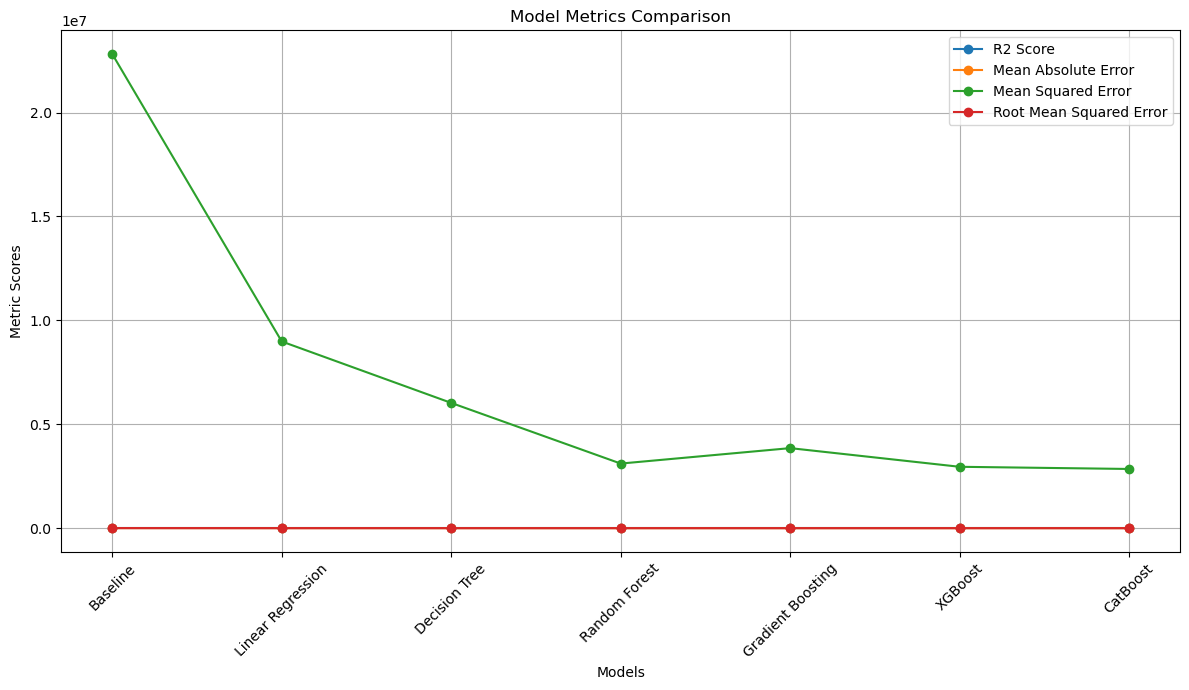

In [20]:
algorithms = list(models.keys())

plt.figure(figsize=(12, 7))

plt.plot(algorithms, df_r2.values, marker='o', label="R2 Score")
plt.plot(algorithms, df_mae.values, marker='o', label="Mean Absolute Error")
plt.plot(algorithms, df_mse.values, marker='o', label="Mean Squared Error")
plt.plot(algorithms, df_rmse.values, marker='o', label="Root Mean Squared Error")

plt.title("Model Metrics Comparison")
plt.xlabel("Models")
plt.ylabel("Metric Scores")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()